# Collaborative Denoising Auto-Encoder (CDAE)

We present a new model-based collaborative filtering (CF) method for top-N recommendation called Collaborative Denoising Auto-Encoder (CDAE). CDAE assumes that whatever
user-item interactions are observed are a corrupted version of the user’s full preference set. The model learns latent representations
of corrupted user-item preferences that can best reconstruct the full
input.
In other words, during training, we feed the model a subset
of a user’s item set and train the model to recover the whole
item set; at prediction time, the model recommends new items to
the user given the existing preference set as input. Training on corrupted
data effectively recovers co-preference patterns. We show
that this is an effective approach for collaborative filtering.

# Acquire Data

In [0]:
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
import sys
import os.path
import tensorflow as tf
import time
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [3]:
!wget -O BX-CSV_Dump.zip http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
!unzip -o BX-CSV_Dump.zip -d data

--2018-10-17 06:22:48--  http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
Resolving www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)... 132.230.105.133
Connecting to www2.informatik.uni-freiburg.de (www2.informatik.uni-freiburg.de)|132.230.105.133|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘BX-CSV_Dump.zip’

BX-CSV_Dump.zip     100%[===================>]  24.88M  10.6MB/s    in 2.4s    

2018-10-17 06:22:51 (10.6 MB/s) - ‘BX-CSV_Dump.zip’ saved [26085508/26085508]

Archive:  BX-CSV_Dump.zip
  inflating: data/BX-Book-Ratings.csv  
  inflating: data/BX-Books.csv       
  inflating: data/BX-Users.csv       


In [4]:
bookdf = pd.read_csv('data/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
bookdf.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
userdf = pd.read_csv('data/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
userdf.columns = ['userID', 'Location', 'Age']
ratingdf = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratingdf.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

Since the dataset is huge, we will filter the books with maximum number of rating and make the dataset with close to 100k ratings

# Filter Data

In [0]:
#filter books and ratings dataset for most rated books
merged_df = pd.merge(ratingdf, bookdf, on='ISBN')
temp_Countdf = (merged_df.
     groupby(by = ['ISBN'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
    
    )

In [6]:
#filter books with totalRatingCount >100
popularity_threshold = 100
temp_Countdf = temp_Countdf.query('totalRatingCount >= @popularity_threshold')
temp_Countdf.head()

,ISBN,totalRatingCount
1759,002542730X,171
3219,0060008032,104
3484,0060096195,107
3989,006016848X,147
4122,0060173289,130


In [7]:
#filter book dataset
print(len(bookdf))
filteredbookdf = bookdf.loc[bookdf['ISBN'].isin(temp_Countdf.ISBN)]
print(len(filteredbookdf))

271360
727


In [8]:
#filter rating dataset
print(len(ratingdf))
filteredRatingDf = ratingdf.loc[ratingdf['ISBN'].isin(temp_Countdf.ISBN)]
print(len(filteredRatingDf))

1149780
137423


In [9]:
#filter user dataset
print(len(userdf))
filteredUserDf = userdf.loc[userdf['userID'].isin(filteredRatingDf.userID)]
print(len(filteredUserDf))

278858
32426


In [10]:
#index book list
filteredbookdf = filteredbookdf.reset_index(drop=True)
filteredbookdf['BookIndex'] = filteredbookdf.index +1
filteredbookdf.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,BookIndex
0,0440234743,The Testament,John Grisham,1999,Dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,1
1,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,2
2,0971880107,Wild Animus,Rich Shapero,2004,Too Far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,3
3,0345402871,Airframe,Michael Crichton,1997,Ballantine Books,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,4
4,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,5


In [11]:
#index user list
filteredUserDf = filteredUserDf.reset_index(drop=True)
filteredUserDf['UserIndex'] = filteredUserDf.index +1
filteredUserDf.head()

,userID,Location,Age,UserIndex
0,9,"germantown, tennessee, usa",NaN,1
1,14,"mediapolis, iowa, usa",NaN,2
2,16,"albuquerque, new mexico, usa",NaN,3
3,26,"bellevue, washington, usa",NaN,4
4,39,"cary, north carolina, usa",NaN,5


In [12]:

#Merging bookdf with ratings_df by ISBN
merged_book_rating = pd.merge(filteredRatingDf, filteredbookdf, on='ISBN')
merged_book_rating = merged_book_rating.drop('ISBN', axis=1).drop('bookTitle', axis=1).drop('bookAuthor', axis=1).drop('yearOfPublication', axis=1).drop('publisher', axis=1)
merged_book_rating = merged_book_rating.drop('imageUrlS', axis=1).drop('imageUrlM', axis=1).drop('imageUrlL', axis=1)
merged_book_rating.head()

,userID,bookRating,BookIndex
0,276727,0,648
1,278418,0,648
2,638,0,648
3,3363,0,648
4,7158,10,648


In [13]:
#Merging userDf with ratings_df by userID
merged_book_rating = pd.merge(merged_book_rating, filteredUserDf, on='userID')
merged_book_rating = merged_book_rating.drop('userID', axis=1).drop('Location', axis=1).drop('Age', axis=1)
merged_book_rating.head()

,bookRating,BookIndex,UserIndex
0,0,648,32195
1,0,648,32375
2,0,617,32375
3,0,95,32375
4,0,687,32375


In [14]:
merged_book_rating = merged_book_rating[['UserIndex', 'BookIndex', 'bookRating']]
merged_book_rating.columns = ['user_id', 'item_id', 'rating']
merged_book_rating.head()

,user_id,item_id,rating
0,32195,648,0
1,32375,648,0
2,32375,617,0
3,32375,95,0
4,32375,687,0


# Model


Similar to the standard Denoising Auto-Encoder, CDAE is also
represented as a one-hidden-layer neural network. The key difference
is that the input also encodes a latent vector for the user, which
allows CDAE to be a much better recommender model. Figure  shows a sample structure of CDAE. CDAE
consists of 3 layers, including the input layer, the hidden layer and
the output layer

![alt text](https://github.com/shreyabansal25/Recommended-Systems/blob/master/CDAE.PNG?raw=true)

In [0]:
# efficient version
def precision_recall_ndcg_at_k(k, rankedlist, test_matrix):
    idcg_k = 0
    dcg_k = 0
    n_k = k if len(test_matrix) > k else len(test_matrix)
    for i in range(n_k):
        idcg_k += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        dcg_k += 1 / math.log(hits[c][0] + 2, 2)

    return float(count / k), float(count / len(test_matrix)), float(dcg_k / idcg_k)


def map_mrr_ndcg(rankedlist, test_matrix):
    ap = 0
    map = 0
    dcg = 0
    idcg = 0
    mrr = 0
    for i in range(len(test_matrix)):
        idcg += 1 / math.log(i + 2, 2)

    b1 = rankedlist
    b2 = test_matrix
    s2 = set(b2)
    hits = [(idx, val) for idx, val in enumerate(b1) if val in s2]
    count = len(hits)

    for c in range(count):
        ap += (c + 1) / (hits[c][0] + 1)
        dcg += 1 / math.log(hits[c][0] + 2, 2)

    if count != 0:
        mrr = 1 / (hits[0][0] + 1)

    if count != 0:
        map = ap / count

    return map, mrr, float(dcg / idcg)


def evaluate(self):
    
    pred_ratings_10 = {}
    pred_ratings_5 = {}
    pred_ratings = {}
    ranked_list = {}
    p_at_5 = []
    p_at_10 = []
    r_at_5 = []
    r_at_10 = []
    map = []
    mrr = []
    ndcg = []
    ndcg_at_5 = []
    ndcg_at_10 = []
    for u in self.test_users:
        user_ids = []
        user_neg_items = self.neg_items[u]
        item_ids = []
        # scores = []
        for j in user_neg_items:
            item_ids.append(j)
            user_ids.append(u)

        scores = self.predict(user_ids, item_ids)
        # print(type(scores))
        # print(scores)
        # print(np.shape(scores))
        # print(ratings)
        neg_item_index = list(zip(item_ids, scores))

        ranked_list[u] = sorted(neg_item_index, key=lambda tup: tup[1], reverse=True)
        pred_ratings[u] = [r[0] for r in ranked_list[u]]
        pred_ratings_5[u] = pred_ratings[u][:5]
        pred_ratings_10[u] = pred_ratings[u][:10]

        p_5, r_5, ndcg_5 = precision_recall_ndcg_at_k(5, pred_ratings_5[u], self.test_data[u])
        p_at_5.append(p_5)
        r_at_5.append(r_5)
        ndcg_at_5.append(ndcg_5)
        p_10, r_10, ndcg_10 = precision_recall_ndcg_at_k(10, pred_ratings_10[u], self.test_data[u])
        p_at_10.append(p_10)
        r_at_10.append(r_10)
        ndcg_at_10.append(ndcg_10)
        map_u, mrr_u, ndcg_u = map_mrr_ndcg(pred_ratings[u], self.test_data[u])
        map.append(map_u)
        mrr.append(mrr_u)
        ndcg.append(ndcg_u)

    print("-----------------------------------------------------")
    #print("precision@10: " + str(np.mean(p_at_10)))
    #print("recall@10: " + str(np.mean(r_at_10)))
    #print("precision@5: " + str(np.mean(p_at_5)))
    #print("recall@5: " + str(np.mean(r_at_5)))
    #print("map: " + str(np.mean(map)))
    #print("mrr: " + str(np.mean(mrr)))
    #print("ndcg: " + str(np.mean(ndcg)))
    #print("ndcg@5: " + str(np.mean(ndcg_at_5)))
    #print("ndcg@10: " + str(np.mean(ndcg_at_10)))
    
    return np.mean(p_at_5), np.mean(r_at_5)

In [0]:
class ICDAE():
    '''
    Based on CDAE and I-AutoRec, I designed the following item based CDAE, it seems to perform better than CDAE slightly.
    '''

    def __init__(self, sess, num_user, num_item, learning_rate=1e-3, reg_rate=0.1, epoch=25, batch_size=100,
                 verbose=False, T=1, display_step=10):
        self.learning_rate = learning_rate
        self.epochs = epoch
        self.batch_size = batch_size
        self.reg_rate = reg_rate
        self.sess = sess
        self.num_user = num_user
        self.num_item = num_item
        self.verbose = verbose
        self.T = T
        self.display_step = display_step
        print("Item based CDAE.")

    def build_network(self, hidden_neuron=500, corruption_level=0):
        self.corrupted_interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.interact_matrix = tf.placeholder(dtype=tf.float32, shape=[None, self.num_user])
        self.item_id = tf.placeholder(dtype=tf.int32, shape=[None])
        self.corruption_level = corruption_level

        W = tf.Variable(tf.random_normal([self.num_user, hidden_neuron], stddev=0.01))
        W_prime = tf.Variable(tf.random_normal([hidden_neuron, self.num_user], stddev=0.01))
        V = tf.Variable(tf.random_normal([self.num_item, hidden_neuron], stddev=0.01))

        b = tf.Variable(tf.random_normal([hidden_neuron], stddev=0.01))
        b_prime = tf.Variable(tf.random_normal([self.num_user], stddev=0.01))
        # print(np.shape(tf.matmul(self.corrupted_interact_matrix, W)))
        # print(np.shape( tf.nn.embedding_lookup(V, self.item_id)))
        layer_1 = tf.sigmoid(tf.matmul(self.corrupted_interact_matrix, W) + b)
        self.layer_2 = tf.sigmoid(tf.matmul(layer_1, W_prime) + b_prime)

        self.loss = - tf.reduce_sum(
            self.interact_matrix * tf.log(self.layer_2) + (1 - self.interact_matrix) * tf.log(1 - self.layer_2)) \
                    + self.reg_rate * (
        tf.nn.l2_loss(W) + tf.nn.l2_loss(W_prime) + tf.nn.l2_loss(b) + tf.nn.l2_loss(b_prime))

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss)

    def prepare_data(self, train_data, test_data):
        self.train_data = self._data_process(train_data).transpose()
        self.neg_items = self._get_neg_items(train_data)
        self.num_training = self.num_item
        self.total_batch = int(self.num_training / self.batch_size)
        self.test_data = test_data
        self.test_users = set([u for u in self.test_data.keys() if len(self.test_data[u]) > 0])
        print("data preparation finished.")

    def train(self):

        idxs = np.random.permutation(self.num_training)  # shuffled ordering

        for i in range(self.total_batch):
            start_time = time.time()
            if i == self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size:]
            elif i < self.total_batch - 1:
                batch_set_idx = idxs[i * self.batch_size: (i + 1) * self.batch_size]

            _, loss = self.sess.run([self.optimizer, self.loss], feed_dict={
                self.corrupted_interact_matrix: self._get_corrupted_input(self.train_data[batch_set_idx, :],
                                                                          self.corruption_level),
                self.interact_matrix: self.train_data[batch_set_idx, :],
                self.item_id: batch_set_idx
                })
            if self.verbose and i % self.display_step == 0:
                print("Index: %04d; cost= %.9f" % (i + 1, np.mean(loss)))
                if self.verbose:
                    print("one iteration: %s seconds." % (time.time() - start_time))

    def test(self):
        self.reconstruction = self.sess.run(self.layer_2, feed_dict={self.corrupted_interact_matrix: self.train_data,
                                                                     self.item_id: range(self.num_item)}).transpose()
        
        precision, recall = evaluate(self)
        return precision, recall, self.reconstruction

    def execute(self, train_data, test_data):
        self.prepare_data(train_data, test_data)
        init = tf.global_variables_initializer()
        self.sess.run(init)
        precision =[]
        recall =[]
        error =[]
        for epoch in range(self.epochs):
            self.train()
            if (epoch) % self.T == 0:
                prec, rec , err= self.test()
                print("Epoch: %04d; " % (epoch), end='')
                precision.append(prec)
                recall.append(rec)
                error.append(np.mean(err))
        return precision, recall, error

    def save(self, path):
        saver = tf.train.Saver()
        saver.save(self.sess, path)

    def predict(self, user_id, item_id):
        return np.array(self.reconstruction[np.array(user_id), np.array(item_id)])

    def _data_process(self, data):
        return np.asmatrix(data)

    def _get_neg_items(self, data):
        neg_items = {}
        for u in range(self.num_user):
            neg_items[u] = [k for k, i in enumerate(data[u]) if data[u][k] == 0]
            # print(neg_items[u])

        return neg_items

    def _get_corrupted_input(self, input, corruption_level):
        return np.random.binomial(n=1, p=1 - corruption_level) * input


In [0]:
def load_data_all(path="https://raw.githubusercontent.com/cheungdaven/DeepRec/master/data/ml100k/movielens_100k.dat", header=['user_id', 'item_id', 'rating', 'time'],
                  test_size=0.2, sep="\t"):
    df = merged_book_rating

    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    train_data, test_data = train_test_split(df, test_size=test_size)
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    
    train_row = []
    train_col = []
    train_rating = []

    train_dict = {}
    for line in train_data.itertuples():
        u = line[1] - 1
        i = line[2] - 1
        train_dict[(u, i)] = 1

    for u in range(n_users):
        for i in range(n_items):
            train_row.append(u)
            train_col.append(i)
            if (u, i) in train_dict.keys():
                train_rating.append(1)
            else:
                train_rating.append(0)
    train_matrix = csr_matrix((train_rating, (train_row, train_col)), shape=(n_users, n_items))
    all_items = set(np.arange(n_items))

    neg_items = {}
    train_interaction_matrix = []
    for u in range(n_users):
        neg_items[u] = list(all_items - set(train_matrix.getrow(u).nonzero()[1]))
        train_interaction_matrix.append(list(train_matrix.getrow(u).toarray()[0]))

    test_row = []
    test_col = []
    test_rating = []
    for line in test_data.itertuples():
        test_row.append(line[1] - 1)
        test_col.append(line[2] - 1)
        test_rating.append(1)
    test_matrix = csr_matrix((test_rating, (test_row, test_col)), shape=(n_users, n_items))

    test_dict = {}
    for u in range(n_users):
        test_dict[u] = test_matrix.getrow(u).nonzero()[1]

    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)

    return train_interaction_matrix, test_dict, n_users, n_items



In [18]:
import matplotlib.pyplot as plt

model ='CDAE'
epochs = 25
num_factors = 10
display_step = 10
batch_size = 100  # 128 for unlimpair
learning_rate = 1e-3  # 1e-4 for unlimpair
reg_rate = 0.1  # 0.01 for unlimpair
train_data, test_data, n_user, n_item = load_data_all(test_size=0.2, sep="\t")

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    model = ICDAE(sess, n_user, n_item)
    model.build_network()
    precision, recall, error = model.execute(train_data, test_data)
    
print('Done!!!')
    
    


Load data finished. Number of users: 32426 Number of items: 727
Item based CDAE.
data preparation finished.
-----------------------------------------------------
Epoch: 0000; -----------------------------------------------------
Epoch: 0001; -----------------------------------------------------
Epoch: 0002; -----------------------------------------------------
Epoch: 0003; -----------------------------------------------------
Epoch: 0004; -----------------------------------------------------
Epoch: 0005; -----------------------------------------------------
Epoch: 0006; -----------------------------------------------------
Epoch: 0007; -----------------------------------------------------
Epoch: 0008; -----------------------------------------------------
Epoch: 0009; -----------------------------------------------------
Epoch: 0010; -----------------------------------------------------
Epoch: 0011; -----------------------------------------------------
Epoch: 0012; ---------------------

**Precision**

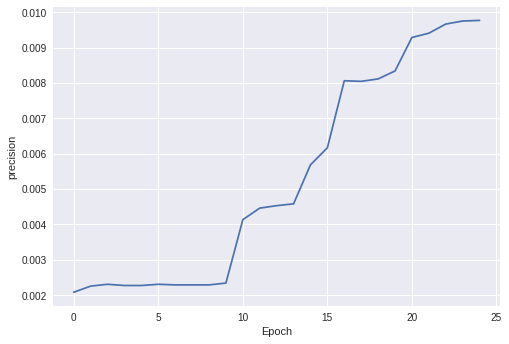

In [19]:
plt.plot(precision)
plt.ylabel('precision')
plt.xlabel('Epoch')
plt.show()
    

**Error**

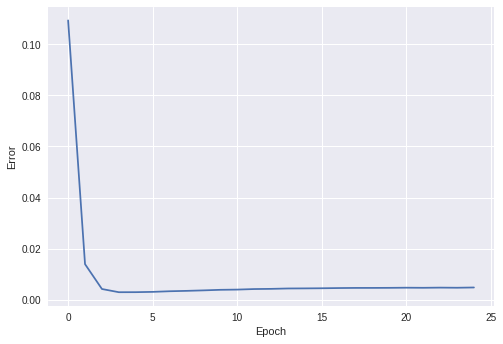

In [20]:
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()